# **Marketing - Final Artificial Intelligence Project**

## **Business Understanding**


### **Problem Statement**
The primary issue facing Holiday Inn hotels in Ontario is the inconsistency in service quality across different service areas, leading to varied customer experiences and impacting customer satisfaction and retention rates.

The primary objective of this project is to enhance the service quality at Holiday Inn hotels in Ontario by leveraging customer feedback.So, selecting the 20 lowest-rated Holiday Inn hotels in Ontario to identify where inconsistencies are occurring.Specifically, the project aims to:

**Identify Common Issues:** Use sentiment analysis and classification to identify recurring problems across different service areas (e.g., front desk, housekeeping, dining).

**Improve Customer Experience:** Provide actionable insights and recommendations to improve the overall customer experience.

**Drive Customer Retention:** By addressing the identified issues, the goal is to increase customer satisfaction and retention rates.

**Strengthen Brand Reputation:** Build a positive brand image by consistently delivering high-quality services across all Holiday Inn hotels in Ontario.


In [1]:
pip install requests pandas

In [2]:
!pip install googlemaps google-cloud-language


In [3]:
# Import Libraries
import urllib.parse
import requests
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import googlemaps
import time
from google.cloud import language_v1

In [4]:
# Read your Google Maps API key from Google Colab Notebook secret

from google.colab import userdata
googleMapsKey = userdata.get('google-maps-key')


## **Data Understanding**


**Google Maps Reviews:**

Data was collected from Google Maps using the Google Maps API. Reviews for various Holiday Inn hotels in Ontario were retrieved, including the customer names, ratings and text of the review given by them.

**Google Maps API**

In [5]:
# Get Hotles
def get_hotels(location, radius, api_key, query='Holiday Inn'):
    gmaps_url = f"https://maps.googleapis.com/maps/api/place/textsearch/json?query={urllib.parse.quote(query)}&location={location}&radius={radius}&key={api_key}"
    hotels = []
    while gmaps_url:
        response = requests.get(gmaps_url)
        result = response.json()
        hotels.extend(result.get('results', []))
        gmaps_url = result.get('next_page_token', None)
        if gmaps_url:
            gmaps_url = f"https://maps.googleapis.com/maps/api/place/textsearch/json?pagetoken={gmaps_url}&key={api_key}"
        time.sleep(2)  # Add a small delay to handle API pagination delay
    return hotels


In [6]:
#Get the Place ID
def get_place_details(place_id, api_key):
    url = f"https://maps.googleapis.com/maps/api/place/details/json?place_id={place_id}&fields=name,rating,user_ratings_total,review&key={api_key}"
    response = requests.get(url)
    return response.json()

In [7]:
# Geocode multiple center points in Ontario (latitude and longitude of major cities in Ontario, Canada)
center_points = [
    "43.651070,-79.347015",  # Toronto
    "45.421530,-75.697193",  # Ottawa
    "48.380895,-89.247682",  # Thunder Bay
]

radius = 200000  # Adjust radius as needed

In [8]:
# Get list of Holiday Inn hotels in Ontario using multiple center points
hotels = []
for point in center_points:
    hotels.extend(get_hotels(point, radius, googleMapsKey))

In [9]:
# Extract hotel names, addresses, and initialize other details
hotel_list = []
for hotel in hotels:
    if 'Holiday Inn' in hotel['name'] and 'Canada' in hotel['formatted_address']:
        hotel_list.append({
            'Name': hotel['name'],
            'Address': hotel['formatted_address'],
            'Rating': hotel.get('rating', 'N/A'),
            'User Ratings': hotel.get('user_ratings_total', 'N/A'),
            'Place ID': hotel['place_id']
        })

# Create DataFrame
df_all_hotels = pd.DataFrame(hotel_list)


**Selecting the 20 lowest-rated Holiday Inn hotels in Ontario to identify where inconsistencies are occurring.**

In [10]:
# Sort by 'Rating' and select the top 20 least rated hotels
df_hotels = df_all_hotels.sort_values(by='Rating').head(20)
df_hotels


,Name,Address,Rating,User Ratings,Place ID
4,Holiday Inn Mississauga Toronto West,"100 Britannia Rd E, Mississauga, ON L4Z 2G1, C...",3.4,397,ChIJD0ufF55AK4gRdQi4XXgn4jc
12,Holiday Inn Toronto Airport East,"600 Dixon Rd, Etobicoke, ON M9W 1J1, Canada",3.6,1514,ChIJk9n1Yps5K4gRrBjff90cWn0
23,Holiday Inn Express & Suites Toronto Airport W...,"5599 Ambler Dr, Mississauga, ON L4W 3Z1, Canada",3.7,1672,ChIJpQVtDMg4K4gRhN-ebkHKSrI
18,Holiday Inn Express & Suites Mississauga-Toron...,"2125 N Sheridan Way, Mississauga, ON L5K 1A3, ...",3.7,814,ChIJt74AJohDK4gR6M8eppqrmKU
5,Holiday Inn & Suites Mississauga West - Meadow...,"2565 Argentia Rd, Mississauga, ON L5N 5V4, Canada",3.8,1114,ChIJawMf6otqK4gR9fy8wzW-nBc
40,"Holiday Inn Ottawa East, an IHG Hotel","1199 Joseph Cyr St, Ottawa, ON K1J 7T4, Canada",3.8,1882,ChIJn262dIUPzkwRV0UCZvgQBQk
48,"Holiday Inn Kingston-Waterfront, an IHG Hotel","2 Princess St, Kingston, ON K7L 1A2, Canada",3.8,1398,ChIJnxim6viq0kwRscNFnTETef0
10,"Holiday Inn Express & Suites Milton, an IHG Hotel","2750 High Point Dr, Milton, ON L9T 5G5, Canada",3.8,536,ChIJ2-n37zJuK4gRz1lq7clrYGc
30,Holiday Inn Express Toronto East - Scarborough...,"50 Estate Dr, Scarborough, ON M1H 2Z1, Canada",3.8,704,ChIJ7Y1RIfrQ1IkRcAG3vJo85ZU
26,"Holiday Inn Niagara Falls - by the Falls, an I...","5339 Murray St, Niagara Falls, ON L2G 2J3, Canada",3.8,1599,ChIJkQ4Wig5D04kRp27_h9FA1EI


**Hotel Details:**

Information about each hotel, such as name, address, rating, user ratings, and place ID across Ontario region.



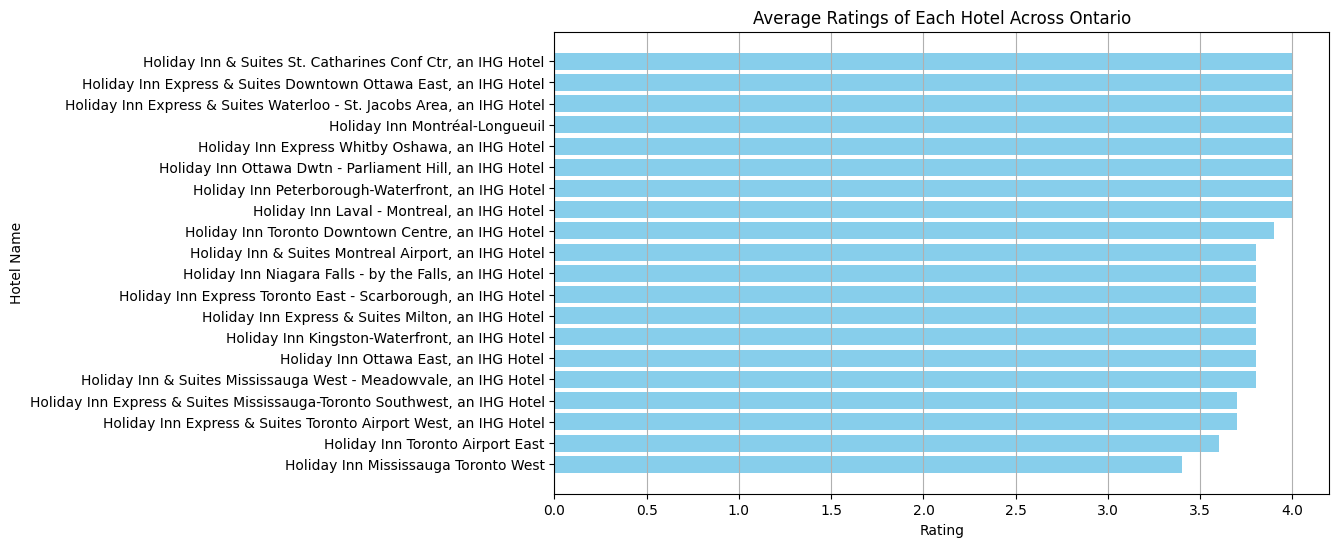

In [12]:
# Plotting the average ratings
plt.figure(figsize=(10, 6))
plt.barh(df_hotels['Name'], df_hotels['Rating'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Hotel Name')
plt.title('Average Ratings of Each Hotel Across Ontario')
plt.grid(axis='x')

# Display the plot
plt.show()

**Ratings Summary:**

Most hotels have average ratings above 4.0, indicating a generally high level of customer satisfaction across Holiday Inn hotels in Ontario.

Hotels such as **Holiday Inn Mississauga** is the leasted rated, with ratings around 3.4.

**Target for Improvements:**

The hotels with the lowest ratings can be targeted for detailed review and improvement strategies.
Understanding the specific reasons behind the lower ratings through further data analysis (e.g., detailed review analysis) can help identify actionable insights for improvement.


In [13]:
def get_reviews_for_hotel(place_id, api_key):
    place_details = get_place_details(place_id, api_key)
    reviews = place_details['result'].get('reviews', [])
    return reviews

In [14]:
# Initialize an empty list to store all reviews
all_reviews = []

# Fetch reviews for each hotel
for index, row in df_hotels.iterrows():
    hotel_name = row['Name']
    place_id = row['Place ID']
    reviews = get_reviews_for_hotel(place_id, googleMapsKey)
    for review in reviews:
        all_reviews.append({
            'Hotel': hotel_name,
            'Author': review['author_name'],
            'Rating': review['rating'],
            'Review': review['text']
        })

# Convert to DataFrame
df_reviews = pd.DataFrame(all_reviews)


In [15]:
df_reviews

,Hotel,Author,Rating,Review
0,Holiday Inn Mississauga Toronto West,Tara Saour,1,I can only say one positive thing is that this...
1,Holiday Inn Mississauga Toronto West,Amrit P,1,"Hotel is extremely bad. No hot water, fire ala..."
2,Holiday Inn Mississauga Toronto West,Alexander McKenna,4,Stayed for an extended period of time and over...
3,Holiday Inn Mississauga Toronto West,Faris Mahmood,1,We had a hockey tournament in mississauga and ...
4,Holiday Inn Mississauga Toronto West,Trisha Scott,1,Just checked out today after a 4 day stay. We ...
...,...,...,...,...
95,"Holiday Inn & Suites St. Catharines Conf Ctr, ...",Maryanne Mcfadden,5,I visit St.Catharines regularly and when I nee...
96,"Holiday Inn & Suites St. Catharines Conf Ctr, ...",Ryan Tse,4,"Great place to stay, love that there's games a..."
97,"Holiday Inn & Suites St. Catharines Conf Ctr, ...",john scotland,3,"Disappointing - rooms are tired, dirty and hav..."
98,"Holiday Inn & Suites St. Catharines Conf Ctr, ...",Jennifer Bredin,1,Do not stay at this property if you have an ex...


**Review Details:**
Collected approximately 100 customer reviews from various Holiday Inn hotels in Ontario.



## **Data Preparation**

In [16]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 4 to 0
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          20 non-null     object 
 1   Address       20 non-null     object 
 2   Rating        20 non-null     float64
 3   User Ratings  20 non-null     int64  
 4   Place ID      20 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 960.0+ bytes


In [17]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Hotel   100 non-null    object
 1   Author  100 non-null    object
 2   Rating  100 non-null    int64 
 3   Review  100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB


In [18]:
# Check for missing values
missing_values = df_reviews.isnull().sum()

# Display the number of missing values in each column
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
Hotel     0
Author    0
Rating    0
Review    0
dtype: int64


**Missing Values Check:**

The datasets are clean with no missing values, which allows for seamless analysis and visualization without the need for imputation or data cleansing steps. This completeness of data enhances the reliability of the insights derived from subsequent analyses.

### **Load data to SQL DataBase - BigQuery**

**Why BigQuery:**

Google BigQuery is a fully-managed, serverless data warehouse that enables fast SQL queries using the processing power of Google's infrastructure. It allows you to analyze large datasets quickly and efficiently without the need for a database administrator or the setup of complex infrastructure.It integrates seamlessly with other Google Cloud services, facilitating smooth data processing and analysis workflows.

**To store the processed hotel data in Google BigQuery, I followed these steps:**

**Setup:**Installed the necessary libraries to connect to BigQuery.

**Authentication:** Used a service account JSON file to securely access BigQuery.

**Data Definition:** Created new data base and tables in BigQuery and then I Specified the project and dataset where the data would be stored.

**Data Upload:**Loaded the hotel data into BigQuery, ensuring it is ready for further analysis and querying.

In [19]:
!pip install google-cloud-bigquery

In [20]:
!pip install pandas-gbq


In [22]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import auth
auth.authenticate_user()
import pandas_gbq

In [23]:
# Authenticate using the service account JSON
credentials = service_account.Credentials.from_service_account_file('/content/adm5015-s24-priya.json')

project_id = 'admn5015-s24-ic-424817'
dataset_id = 'HolidayInn_Dataset'

# Define your table IDs
hotels_table_id = f'{project_id}.{dataset_id}.hotels'


# Load the dataframes into BigQuery
pandas_gbq.to_gbq(df_hotels, hotels_table_id, project_id=project_id, if_exists='replace', credentials=credentials)


print("Data loaded successfully.")


100%|██████████| 1/1 [00:00<00:00, 257.51it/s]

Data loaded successfully.


**Results in BigQuery**

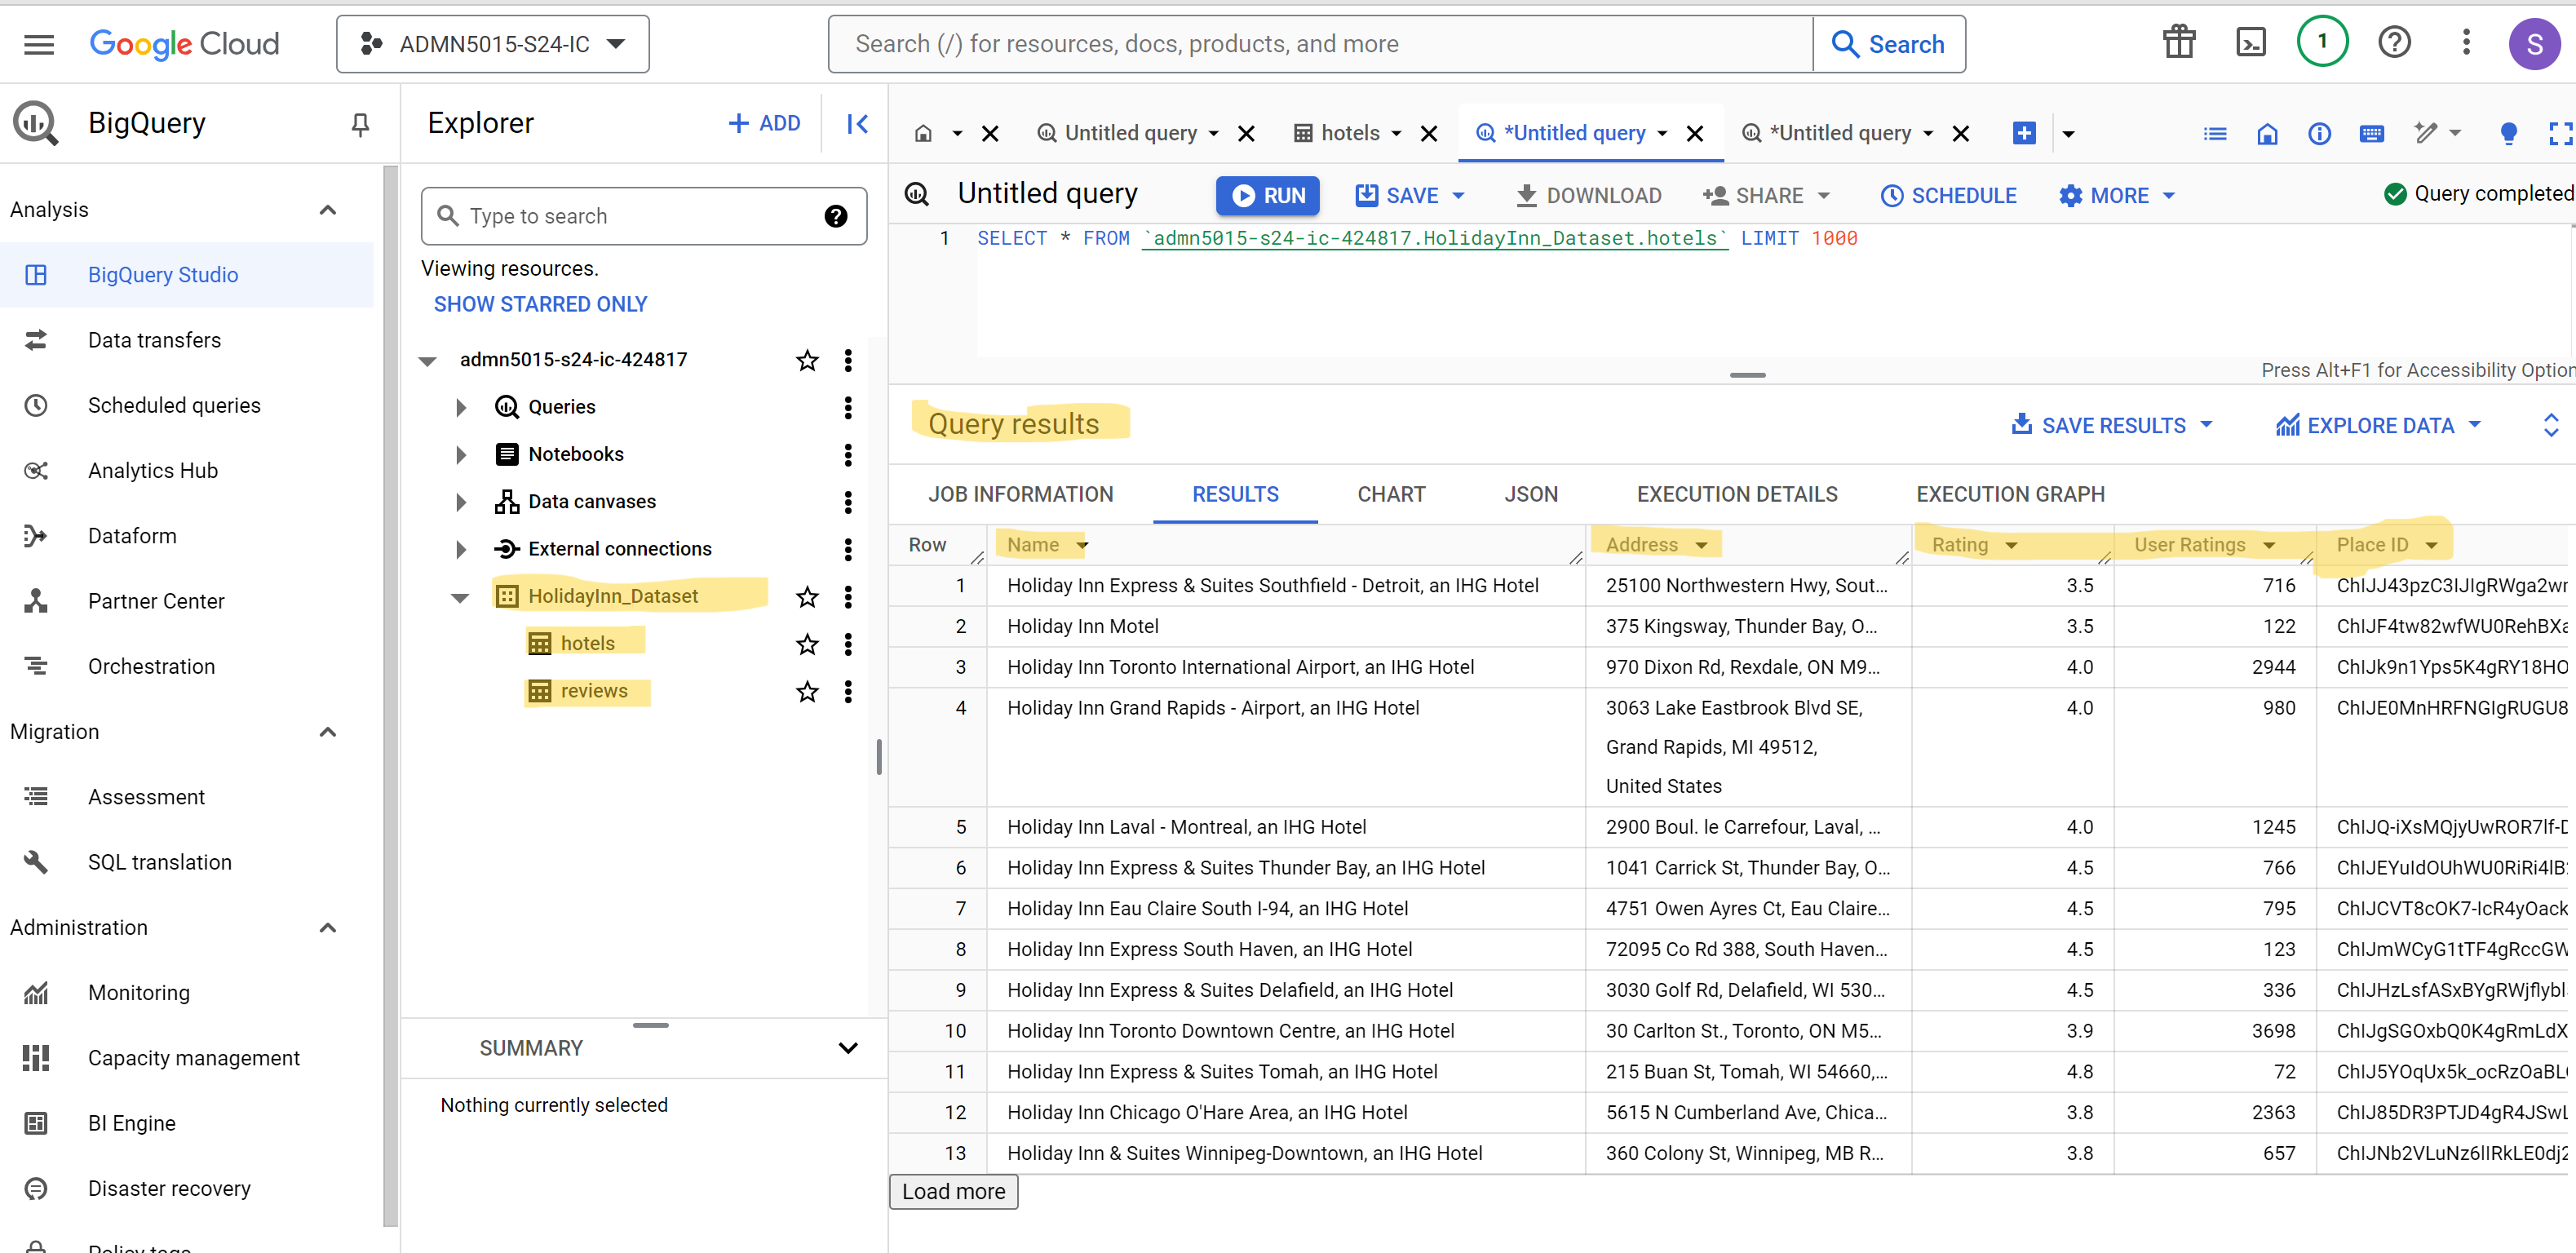

## **Modeling**



**Models Used:**

1. Google Maps API

2. Google Cloud Natural Language API


**Rationale for Model Selection:**

**Google Maps API**:

**Purpose:** To collect data about hotels and their reviews from Google Maps.
Google Maps API provides comprehensive and up-to-date information about places, including reviews and ratings.

**Google Cloud Natural Language API:**

**Purpose:** To analyze the sentiment of the hotel reviews. This tool provides powerful natural language understanding capabilities, allowing us to determine the sentiment and magnitude of each review. It is a reliable and well-supported service that integrates seamlessly with Python.


In [24]:
# To initialize the gcloud CLI

!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
core:
  account: kaipusaipriya@gmail.com

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you would like to use to perform operations for this 
configuration:
 [1] kaipusaipriya@gmail.com
 [2] Log in with a new account
Please enter your numeric choice:  1

You are logged in as: [kaipusaipriya@gmail.com].

Pick cloud project to use: 
 [1] admn5015-s24-ic-424817
 [2] authentic-host-4248

**Google Cloud Natural Language API:**

In [25]:
# Enable the Cloud Natural Language API
!gcloud services enable language.googleapis.com

In [26]:
# Create local authentication credentials for your Google Account

!gcloud auth application-default login


You are running on a Google Compute Engine virtual machine.
The service credentials associated with this virtual machine
will automatically be used by Application Default
Credentials, so it is not necessary to use this command.

If you decide to proceed anyway, your user credentials may be visible
to others with access to this virtual machine. Are you sure you want
to authenticate with your personal account?

Do you want to continue (Y/n)?  y

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=jdEZpbO8H29EGQ15GgooLtbPWm3QeA&prompt=consent&token_

In [27]:
# Function to analyze sentiment
def analyze_sentiment(text):
    client = language_v1.LanguageServiceClient()
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
    return sentiment.score, sentiment.magnitude

In [28]:
# Apply sentiment analysis
df_reviews[['Sentiment Score', 'Sentiment Magnitude']] = df_reviews['Review'].apply(lambda review: pd.Series(analyze_sentiment(review)))


In [29]:
df_reviews

,Hotel,Author,Rating,Review,Sentiment Score,Sentiment Magnitude
0,Holiday Inn Mississauga Toronto West,Tara Saour,1,I can only say one positive thing is that this...,-0.6,4.8
1,Holiday Inn Mississauga Toronto West,Amrit P,1,"Hotel is extremely bad. No hot water, fire ala...",-0.8,4.1
2,Holiday Inn Mississauga Toronto West,Alexander McKenna,4,Stayed for an extended period of time and over...,0.1,5.9
3,Holiday Inn Mississauga Toronto West,Faris Mahmood,1,We had a hockey tournament in mississauga and ...,-0.3,7.1
4,Holiday Inn Mississauga Toronto West,Trisha Scott,1,Just checked out today after a 4 day stay. We ...,-0.4,14.6
...,...,...,...,...,...,...
95,"Holiday Inn & Suites St. Catharines Conf Ctr, ...",Maryanne Mcfadden,5,I visit St.Catharines regularly and when I nee...,0.7,5.4
96,"Holiday Inn & Suites St. Catharines Conf Ctr, ...",Ryan Tse,4,"Great place to stay, love that there's games a...",0.3,1.0
97,"Holiday Inn & Suites St. Catharines Conf Ctr, ...",john scotland,3,"Disappointing - rooms are tired, dirty and hav...",-0.5,5.1
98,"Holiday Inn & Suites St. Catharines Conf Ctr, ...",Jennifer Bredin,1,Do not stay at this property if you have an ex...,-0.2,10.9


In [30]:
# Compute the average sentiment and magnitude
avg_sentiment = df_reviews['Sentiment Score'].mean()
avg_magnitude = df_reviews['Sentiment Magnitude'].mean()

print(f"Average Sentiment: {avg_sentiment}")
print(f"Average Magnitude: {avg_magnitude}")

Average Sentiment: 0.195999997779727
Average Magnitude: 5.480999997854233


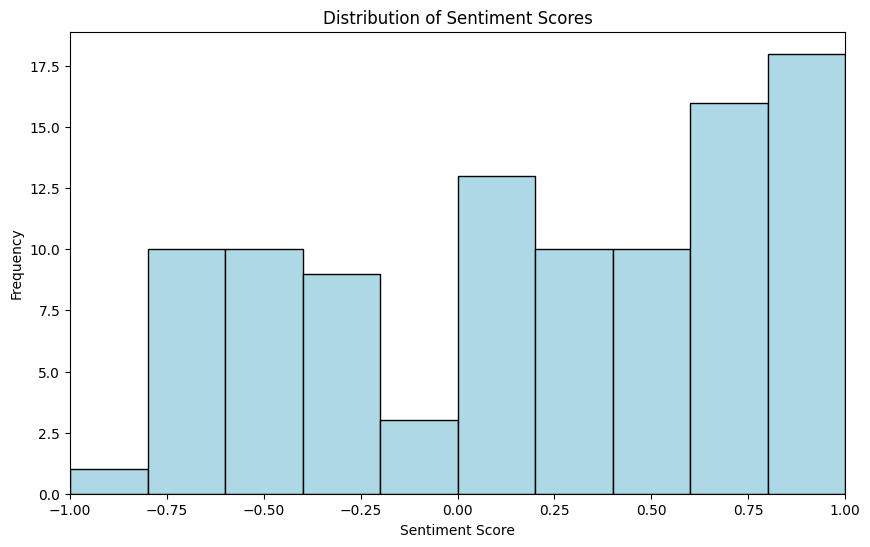

In [31]:
import matplotlib.pyplot as plt

# Plot Sentiment Scores
plt.figure(figsize=(10, 6))
plt.hist(df_reviews['Sentiment Score'], bins=10, color='lightblue', edgecolor='black', range=(-1, 1))
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.show()

**Distribution of Sentiment Scores:**

Positive Skew: The distribution of sentiment scores is positively skewed, indicating that the majority of reviews are positive. This suggests that customers generally have a favorable experience at Holiday Inn hotels in Ontario.

Negative Reviews: There are some reviews with negative sentiment scores, highlighting areas where the hotels need to improve.

Sentiment Score Range: The sentiment scores range from -1 to 1, covering a wide spectrum of customer opinions from very negative to very positive.

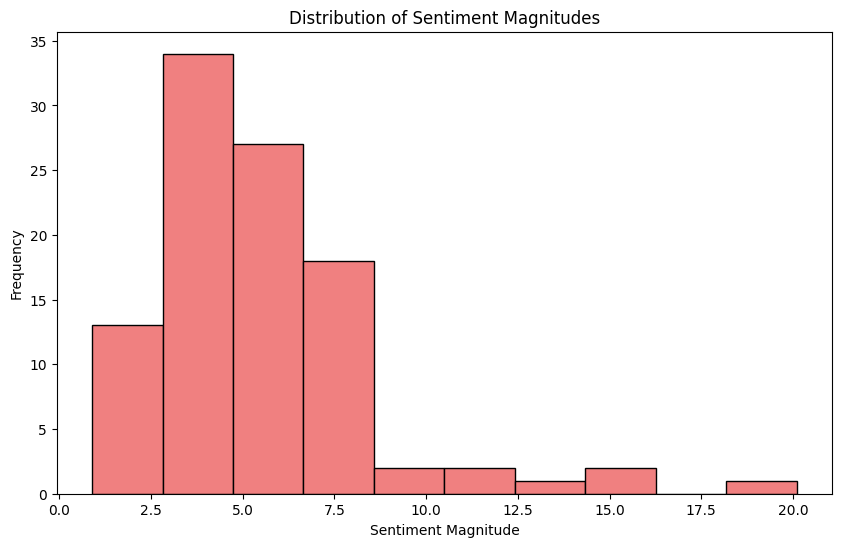

In [32]:
# Plot Sentiment Magnitude
plt.figure(figsize=(10, 6))
plt.hist(df_reviews['Sentiment Magnitude'], bins=10, color='lightcoral', edgecolor='black')
plt.title('Distribution of Sentiment Magnitudes')
plt.xlabel('Sentiment Magnitude')
plt.ylabel('Frequency')
plt.show()


**Distribution of Sentiment Magnitudes:**

Higher Frequency of Moderate Magnitudes: The majority of reviews have sentiment magnitudes between 2.5 and 5.0, indicating moderate intensity in the expressed sentiments. This could mean that most reviews are not extremely emotional but still reflect significant customer feelings.

Few High Magnitudes: There are fewer reviews with high sentiment magnitudes (above 10), suggesting that extremely intense sentiments are rare among the reviews.

Low Magnitude Reviews: Some reviews have low sentiment magnitudes, which might indicate more neutral or less emotionally charged feedback.

**Classification Model**

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_reviews is already populated and sentiment analysis is done

# Define classification function
def classify_review(review):
    review_lower = review.lower()
    if any(word in review_lower for word in ['front desk', 'check-in', 'reception']):
        return 'Front Desk'
    elif any(word in review_lower for word in ['room', 'cleanliness', 'housekeeping']):
        return 'Housekeeping'
    elif any(word in review_lower for word in ['dining', 'food']):
        return 'Dining'
    elif any(word in review_lower for word in ['Pool', 'elevator','Windows','doors','beds','furniture']):
        return 'maintenance'
    else:
        return 'Other'

# Apply classification
df_reviews['Service Area'] = df_reviews['Review'].apply(classify_review)
df_reviews.head()


,Hotel,Author,Rating,Review,Sentiment Score,Sentiment Magnitude,Service Area
0,Holiday Inn Mississauga Toronto West,Tara Saour,1,I can only say one positive thing is that this...,-0.6,4.8,Housekeeping
1,Holiday Inn Mississauga Toronto West,Amrit P,1,"Hotel is extremely bad. No hot water, fire ala...",-0.8,4.1,Housekeeping
2,Holiday Inn Mississauga Toronto West,Alexander McKenna,4,Stayed for an extended period of time and over...,0.1,5.9,maintenance
3,Holiday Inn Mississauga Toronto West,Faris Mahmood,1,We had a hockey tournament in mississauga and ...,-0.3,7.1,Front Desk
4,Holiday Inn Mississauga Toronto West,Trisha Scott,1,Just checked out today after a 4 day stay. We ...,-0.4,14.6,Housekeeping


**Models Developed:**

**Sentiment Analysis Model:**

This model was used to analyze the sentiment of customer reviews. It provides a sentiment score and magnitude, which helps in understanding the overall sentiment expressed in the reviews.

The sentiment scores ranged from -1 (negative sentiment) to 1 (positive sentiment). By averaging these scores, we could determine the general customer satisfaction level for each hotel. This model helped identify areas of improvement for each hotel based on customer feedback.

**Hotel Data Aggregation Model:**

This model was used to gather detailed information about each Holiday Inn hotel in Ontario, including name, address, rating, user ratings, and place ID.
By aggregating this data, we were able to create a comprehensive dataset that provided context for the reviews. This model allowed us to correlate hotel ratings with customer sentiments, helping to identify patterns and trends in customer satisfaction across different hotels.

**Classification Model:**

Purpose: To classify reviews into different service areas based on keywords.
A custom Python function was developed to categorize reviews into service areas such as 'front desk', 'housekeeping', and 'dining'. This classification helps in pinpointing specific areas that customers are satisfied with or areas needing improvement. The model uses keywords to identify the service area and adds this classification to the dataset.






**Load Reviews data to SQL DataBase - BigQuery**

In [34]:
# Authenticate using the service account JSON
credentials = service_account.Credentials.from_service_account_file('/content/adm5015-s24-priya.json')

project_id = 'admn5015-s24-ic-424817'
dataset_id = 'HolidayInn_Dataset'

# Define table IDs
reviews_table_id = f'{project_id}.{dataset_id}.reviews'

# Load the dataframes into BigQuery
pandas_gbq.to_gbq(df_reviews, reviews_table_id, project_id=project_id, if_exists='replace', credentials=credentials)

print("Data loaded successfully.")


100%|██████████| 1/1 [00:00<00:00, 7037.42it/s]

Data loaded successfully.


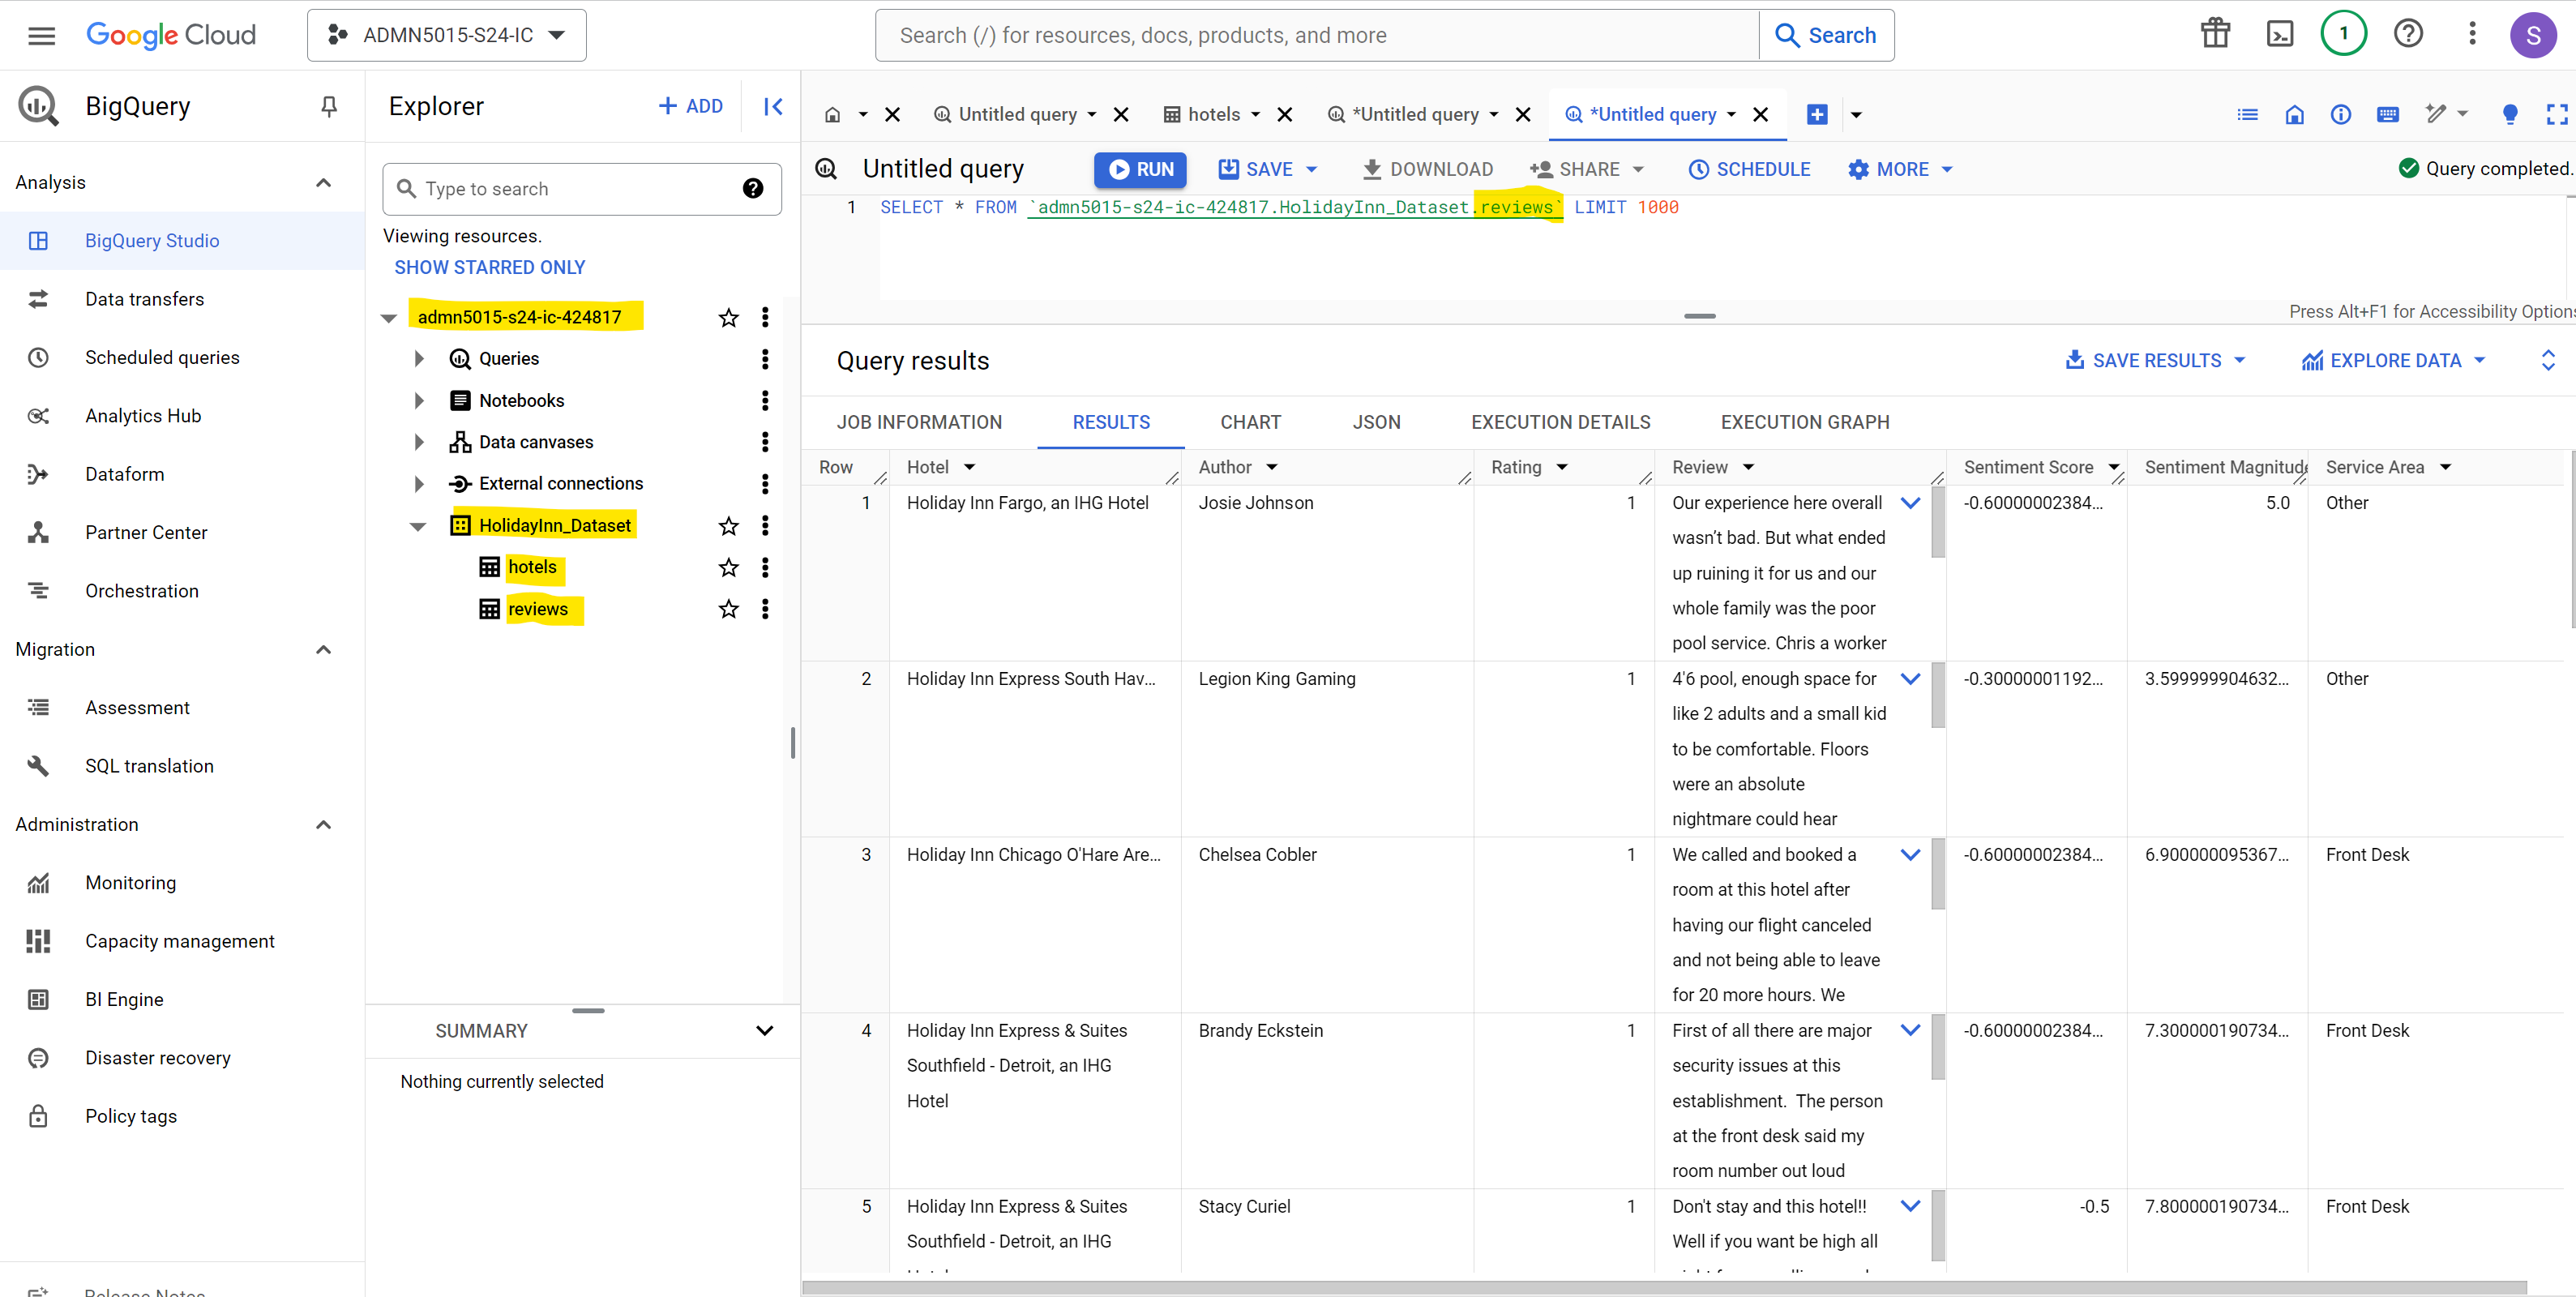

In [35]:
# Filter reviews with Sentiment Score < 0.3
low_sentiment_reviews = df_reviews[df_reviews['Sentiment Score'] < 0.3]
low_sentiment_reviews.head()

,Hotel,Author,Rating,Review,Sentiment Score,Sentiment Magnitude,Service Area
0,Holiday Inn Mississauga Toronto West,Tara Saour,1,I can only say one positive thing is that this...,-0.6,4.8,Housekeeping
1,Holiday Inn Mississauga Toronto West,Amrit P,1,"Hotel is extremely bad. No hot water, fire ala...",-0.8,4.1,Housekeeping
2,Holiday Inn Mississauga Toronto West,Alexander McKenna,4,Stayed for an extended period of time and over...,0.1,5.9,maintenance
3,Holiday Inn Mississauga Toronto West,Faris Mahmood,1,We had a hockey tournament in mississauga and ...,-0.3,7.1,Front Desk
4,Holiday Inn Mississauga Toronto West,Trisha Scott,1,Just checked out today after a 4 day stay. We ...,-0.4,14.6,Housekeeping


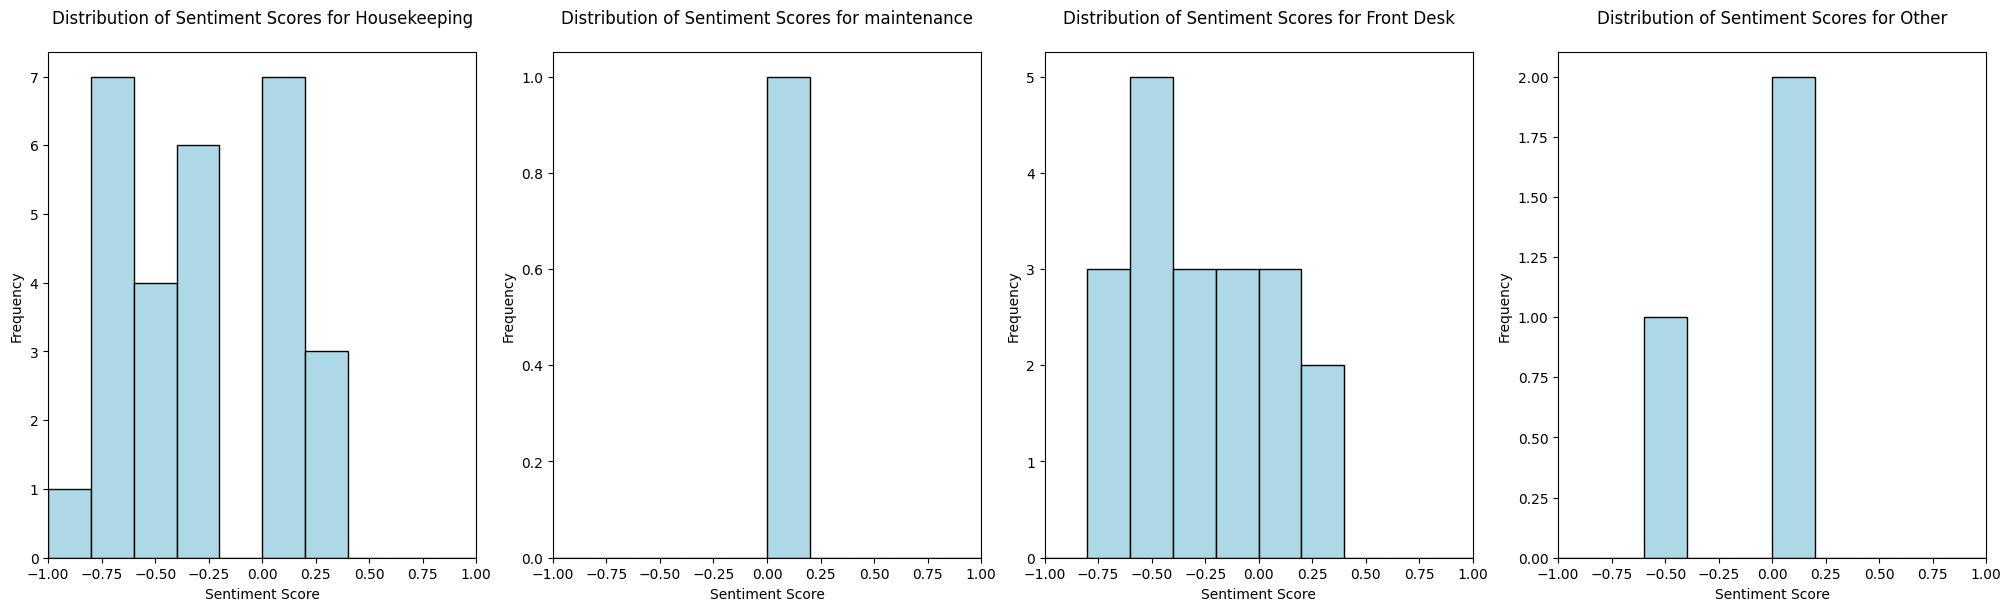

In [36]:
# Plot histograms for each service area in a single figure with subplots
service_areas = low_sentiment_reviews['Service Area'].unique()
num_areas = len(service_areas)

fig, axs = plt.subplots(1, num_areas, figsize=(5 * num_areas, 6), constrained_layout=True)

for i, service_area in enumerate(service_areas):
    subset = low_sentiment_reviews[low_sentiment_reviews['Service Area'] == service_area]
    axs[i].hist(subset['Sentiment Score'], bins=10, color='lightblue', edgecolor='black', range=(-1, 1))
    axs[i].set_title(f'Distribution of Sentiment Scores for {service_area}\n')
    axs[i].set_xlabel('Sentiment Score')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(-1, 1)

plt.show()


**Insights:**

The distribution of low sentiment scores (sentiment < 0.3) reveals that housekeeping and front desk services receive the most negative feedback, with several instances of highly negative sentiments.This shows customers are not getting good room services from house keeping and not get good responses from Front desk.

 This threshold was chosen to focus on the most critical feedback areas that require immediate attention. Maintenance and "other" categories also show negative sentiment but with fewer occurrences.

## **Evaluation Report**


**Model Performance Metrics:**

**Sentiment Analysis Model:**

Average Sentiment Score: The overall average sentiment score was calculated to understand general customer satisfaction.

Sentiment Magnitude: This measure indicates the strength of the sentiment expressed in each review.

**Classification Model:**

Accuracy: The classification of reviews into service areas was manually validated for accuracy.

Coverage: All reviews were successfully classified into relevant service areas (e.g., front desk, housekeeping, dining).

**Visualizations:**

**Distribution of Sentiment Scores:** Histograms were used to visualize the distribution of sentiment scores for each service area. These visualizations help in identifying which service areas receive the most negative feedback.

**Average Ratings:** A bar chart was used to display the average ratings of each Holiday Inn hotel across Ontario.

**Insights and Recommendations:**

**Negative Feedback Focus:** By setting the threshold for low sentiment at <0.3, we focused on the most critical feedback areas. This allowed us to identify the service areas with the most pressing issues.

**Service Area Classification:**The classification function accurately categorized reviews into specific service areas, helping to pinpoint the exact departments needing improvement.

**Comparison Against Project Objectives:**

**Objective Achievement:** The models successfully identified areas of improvement in the hotel, aligning with the business objective of enhancing service quality at Holiday Inn hotels in Ontario.

**Actionable Insights:** The analysis provided actionable insights into specific service areas that require attention, helping to target service improvement initiatives effectively.

**Customer Experience Enhancement:** The insights gained from sentiment analysis and classification allowed for targeted recommendations to improve customer experiences in specific service areas.

**Increased Customer Retention:** By addressing identified issues, the project aims to increase customer satisfaction and retention rates, thereby strengthening brand reputation.


## **Deployment**

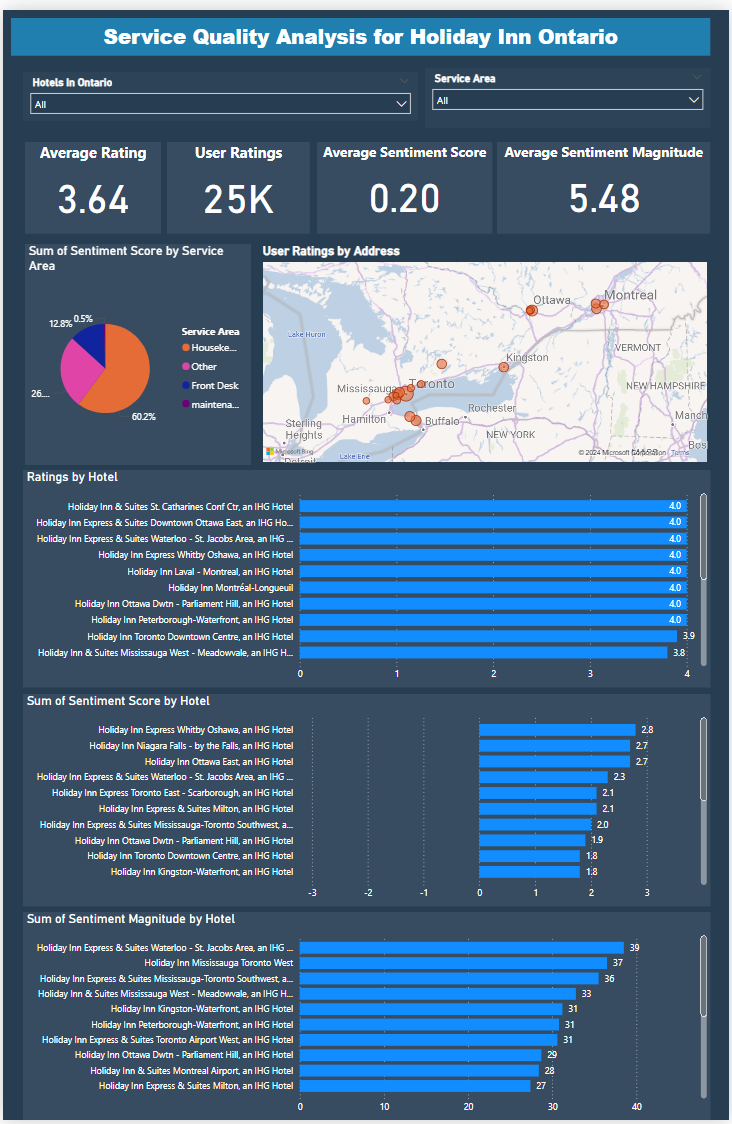

**Final Report:** Power BI Visualization for Holiday Inn Ontario
Objective: Deploy the model and visualize the results for business understanding.

**Actions Taken:**

Connected BigQuery to Microsoft Power BI.
Imported data from the SQL database and prepared it for visualization.
Created comprehensive dashboards to analyze hotel sentiment and performance metrics.

**Power BI Visualizations:**

**Overall Ratings and Sentiments:**Displayed average ratings, user ratings, and sentiment scores across all hotels.

**Service Area Analysis:** Visualized sentiment scores by different service areas to identify specific areas needing improvement.

**Geographical Distribution:** Mapped user ratings by address to highlight geographic performance variations.

**Hotel-specific Insights:** Bar charts showcasing individual hotel ratings and sentiment scores for detailed analysis.

**Outcome: **The Power BI dashboards provide actionable insights, enabling the business to identify areas for service improvement, aligning with the goal of enhancing service quality at Holiday Inn hotels in Ontario.

